In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import numpy as np
from scipy import optimize
import os
import json
from matplotlib import pyplot as plt
import matplotlib

from collections import defaultdict

In [5]:
param_names = [
                 'num_trains',
                 'qf_lr',

               ]
param_full_names = [
                 'algorithm_args/num_trains_per_train_loop',
                 'qf_lr',

                    ]
result_names = [
                'expl_num_correct',
                'expl_successes',
                'expl_noop',

                'qf_loss',
                'Q_values_mean',
                'Q_values_std',

                ]
result_full_names = [
                     'exploration/env_infos/num_correct_Mean',
                     'exploration/env_infos/final/task_success_Mean',
                     'exploration/env_infos/noop_Mean',
                    'trainer/QF_Loss',
                    'trainer/Q_Predictions_Mean',
                    'trainer/Q_Predictions_Std',
                    ]

tests = ['pretrain/']


In [8]:
paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[]) 
paths = sorted(paths, key=lambda x: x[0])

class Reader:
    def read(self,paths,name='pretrain.csv'):
        dfs = []
        for path,test in paths:
            try:
                df = pd.read_csv(os.path.join(path,name))
                dfs.append(df)
            except:
                continue
        return dfs
    
dfs = Reader().read(paths)
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
def smooth(x):
    return np.convolve(x, np.ones(window), 'valid') / window

def plot(dfs):
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        for indices, label in index_sets:
            data = [smooth(dfs[i][metric]) for i in indices if metric in dfs[i].keys()]
            min_len = min([len(x) for x in data])
            data = [x[:min_len] for x in data]
            if len(data) > 0:
                std_error = np.std(data, axis=0) / np.sqrt(len(indices)) 
                mean = np.mean(data, axis=0)
                plt.plot(mean, label=label)
                plt.fill_between(np.arange(len(mean)), mean-std_error, mean+std_error, alpha=0.1)
        plt.title('offline ' + metric)
        plt.xlabel('Epochs')
        plt.legend()

metrics = ['evaluation/env_infos/final/task_success Mean',
   'evaluation/path length Mean',
  ]

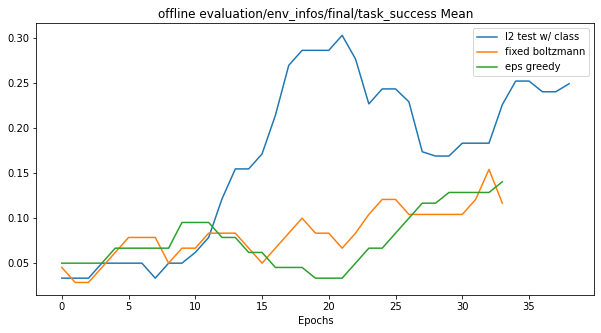

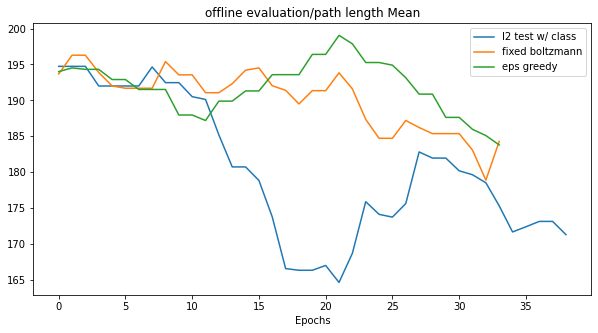

In [112]:
tests = ['a-test']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])

paths = sorted(paths, key=lambda x: x[0])

dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
i0 = [0], 'l2 test w/ class'
i1 = [1], 'fixed boltzmann'
i2 = [2], 'eps greedy'
i3 = [3], 'her'

index_sets = [i0, i1, i2]
window = 10
plot(dfs)

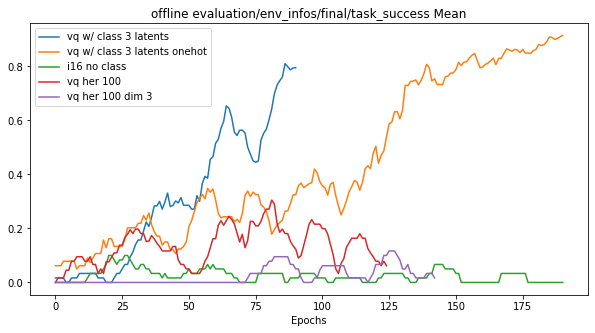

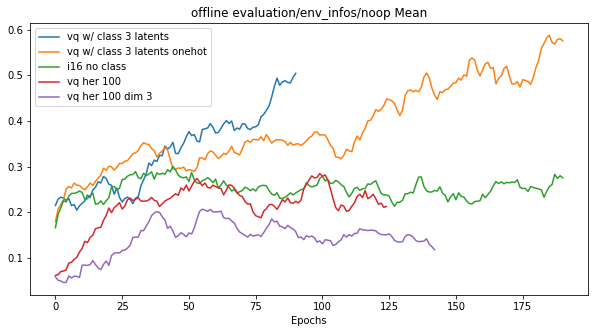

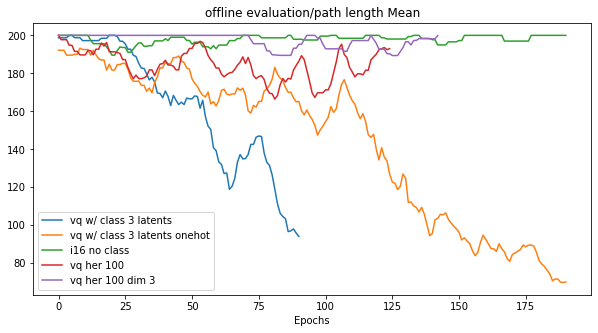

In [177]:
tests = ['pretrain/', 'vq/']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])

paths = sorted(paths, key=lambda x: x[0])

tests = ['vq-her/']
new_paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[]) 

new_paths = sorted(new_paths, key=lambda x: x[0])
paths += new_paths


dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
# beta = 0.1
i0 = [0], 'pretrain no class'
i1 = [1], 'pretrain'
i2 = [2], 'pretrain 0.1 class'
i3 = [3], 'pretrain no backprop encoder'
i4 = [4], 'i3 again'
i5 = [5], 'i3 continue'
i6 = [6], 'i3 adjusted hyperparams'
i7 = [7], 'i6 + ln'
i8 = [8], 'i5 sparse'

# bugged?
i9 = [9], 'vq'
i10 = [10], 'vq w/ class'
i11 = [11], 'vq w/ class, small buffer'
i12 = [12], 'i11 3 latents'
i13 = [13], 'i11 3 latents adjust vq loss'

# gaze
i14 = [14], 'vq w/ class 3 latents'

# goal pos
i15 = [15], 'vq w/ class 1 latent'
i16 = [16], 'vq w/ class 3 latents onehot'
i17 = [17], 'vq w/ class 3 latents'
i18 = [18], 'debug'
i19 = [19], 'i16 no class'

i20 = [20], 'vq her'
i21 = [21], 'vq her 100'
i22 = [22], 'vq her 100 dim 3 '

# i14 = [14], 'her sampling'
# i15 = [15], 'her'
# i16 = [16], 'i15 continue'
# i17 = [17], 'her encoder test no freeze'
# i18 = [18], 'her encoder test freeze'
# i19 = [19], 'vq her'

index_sets = [i14, i16, i19, i21, i22]#[i5, i3, i11, i14, i15, i16, i19]
window = 10
plot(dfs)

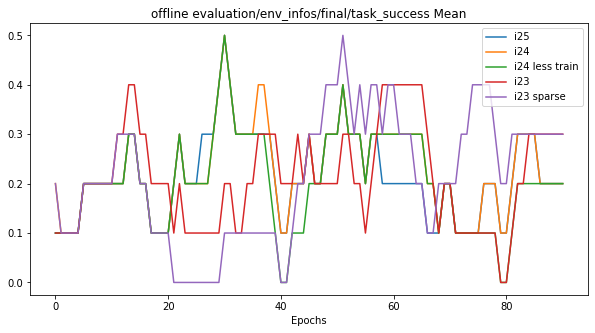

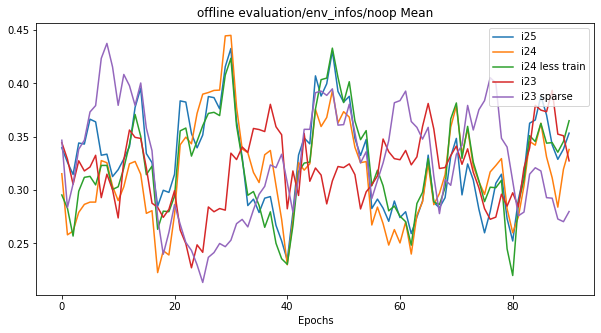

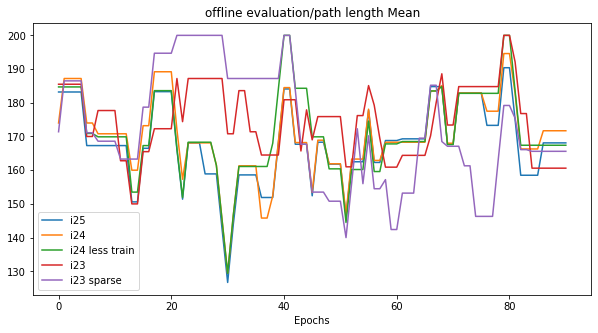

In [164]:
tests = ['encoder-tests/']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[]) 
paths = sorted(paths, key=lambda x: x[0])

dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
i0 = [0], 'No freeze'
i1 = [1], 'Freeze'
i2 = [2], 'Freeze except head'

i3 = [3], 'Sparse pretrain no freeze'
i4 = [4], 'Sparse pretrain freeze'
i5 = [5], 'Sparse pretrain freeze except head'


i6 = [6], 'Sparse pretrain no freeze w/ rew fn train'
i7 = [7], 'Sparse pretrain freeze w/ rew fn train'
i8 = [8], 'Sparse pretrain freeze except head w/ rew fn train'

    
i9 = [9], 'No freeze w/ rew fn train'
i10 = [10], 'Freeze w/ rew fn train'
i11 = [11], 'Freeze except head w/ rew fn train'

    
i12 = [12], 'No KL no freeze'
i13 = [13], 'No KL no freeze'
i14 = [14], 'No KL freeze except head'

i15 = [15], 'No KL no freeze w/ rew fn train'
i16 = [16], 'No KL freeze w/ rew fn train'
i17 = [17], 'No KL freeze except head w/ rew fn train'

i18 = [18], 'No freeze dense'
i19 = [19], 'Freeze dense'
i20 = [20], 'Freeze except head dense'

# 100 trajs gaze

i21 = [21], 'No freeze dense gaze'
i22 = [22], 'Freeze dense gaze'

i23 = [23], 'Freeze dense gaze w/ rew'
i24 = [24], 'No freeze dense gaze w/ rew'

i25 = [25], 'No freeze dense gaze w/ rew no beta'

# gaze init
i26 = [26], 'i25'
i27 = [27], 'i24'
i28 = [28], 'i24 less train'
i29 = [29], 'i23'
i30 = [30], 'i23 sparse'




index_sets = [i26, i27, i28, i29, i30] #[i0, i1, i2, i3, i4, i5]
window = 10
plot(dfs)

In [259]:
tests = ['gaze-sanity/']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[]) 
paths = sorted(paths, key=lambda x: x[0])

dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    

# i0 = [0], '1 switch sanity'
# i1 = [1], 'sanity'
# i2 = [2], 'qr sanity'

# i0 = [0], 'shaped 10'
# i1 = [1], 'bc'
# i2 = [2], 'shaped qr 10'
# i3 = [3], 'sparse 10'
# i4 = [4], 'sparse 10 squash'

# beta = 1
i0 = [0], 'VAE init'
i1 = [1], 'Random init'
i2 = [2], 'Direct gaze'
i3 = [3], 'VAE init w/ sampling training (and target)'
i4 = [4], 'i0 train w/ diff eps'
i5 = [5], 'VAE init w/ reward loss'

# beta = 0.1
i6 = [6], '(1) Goal Pos Input, L2 Rew'
i7 = [7], '(2) Goal Pos Input, L2 Rew (cont.)'
i8 = [8], '(3) Gaze, Sparse -1 Rew, Init w/ (2) and VAE'

i9 = [9], 'i6 w/ sampling training (beta=0.1)'
i10 = [10], 'i6 w/ sampling training (beta=1)'
i11 = [11], '(4) Goal Pos Input, L2 Rew, w/ sampling training'
i12 = [12], 'i7 gaze transfer'
i13 = [13], 'Eval on Training Gaze'#'(5) Gaze, Sparse -1 Rew, Init w/ (4) and VAE'

# actual eval gaze
i14 = [14], 'Eval on Validation Gaze'
i15 = [15], 'i13 20'
i16 = [16], 'i15 latent train'
i17 = [17], 'i13 50'
i18 = [18], 'i17 latent train'

index_sets = [i14, i15, i16, i17, i18]
window = 10
plot(dfs)
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/jensen/Documents/rail/CursorControl/image/logs/gaze-sanity/'

In [73]:
import h5py
import torch

data = h5py.File('rl/gaze_capture/gaze_data.h5', 'r')
state = torch.load('rl/gaze_capture/checkpoint.pth.tar')['state_dict']
weights = state['fc.2.weight'].cpu().detach().numpy().T
bias = state['fc.2.bias'].cpu().detach().numpy().T
features = []
for key in data.keys():
    features.append(data[key][()][0])
    # pos = data[key][()] @ weights + bias
    # plt.scatter(pos[:, 0], pos[:, 1], label=key)
#plt.legend()
for i, f1 in enumerate(features):
    for f2 in features[i + 1:]:
        print(np.linalg.norm(f1 - f2))

1.1328684
1.6379217
1.3652909


loaded demos/int_OneSwitch_sim_gaze_on_policy_100_all_debug_1615418204600284881.npy
loaded demos/int_OneSwitch_sim_goal_model_on_policy_1000_all_debug_1615835470059229510.npy


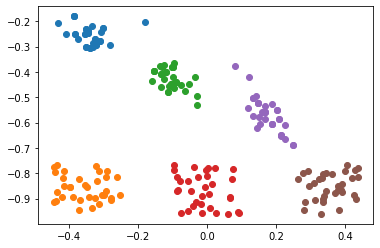

In [127]:
from rlkit.util.io import load_local_or_remote_file
from mpl_toolkits.mplot3d import Axes3D

rl_gaze = h5py.File('rl/gaze_capture/gaze_data_rl.h5', 'r')

gaze_demo_path = 'demos/int_OneSwitch_sim_gaze_on_policy_100_all_debug_1615418204600284881.npy'
gaze_demos = load_local_or_remote_file(gaze_demo_path)
gaze = [[], [], []]
for path in gaze_demos:
    target = np.where(path['env_infos'][1]['target_string'] == 0)[0][0]
    gaze[target].append(path['observations'][1][-128:])
    
pos_path = 'demos/int_OneSwitch_sim_goal_model_on_policy_1000_all_debug_1615835470059229510.npy'
pos_demos = load_local_or_remote_file(pos_path)
pos = [[], [], []]
for path in pos_demos[:100]:
    target = np.where(path['env_infos'][1]['target_string'] == 0)[0][0]
    pos[target].append(path['observations'][1][-128:-125])
pos = [np.array(x) for x in pos]
    
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_12_27_01_0000--s-0/pretrain.pkl'
#discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_14_39_16_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_14_54_25_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_16_21_52_57_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/sparse-mixed/sparse_mixed_2021_03_15_21_16_50_0000--s-0/pretrain.pkl'
#discrim_policy_path = 'logs/sparse-mixed/sparse_mixed_2021_03_17_14_09_47_0000--s-0/pretrain.pkl'


policy = torch.load(discrim_policy_path, map_location=torch.device("cpu"))


fig = plt.figure()
#ax = Axes3D(fig)

# for key in rl_gaze.keys():
for i in range(3):
    rl = rl_gaze[str(i)][()]
    rl_pred = 0
    gaze_pred = 0

#     encoders = policy['qf'].gaze_encoders
#     for encoder in encoders:
#         rl_pred += encoder(torch.Tensor(rl)).detach().numpy()
#         gaze_pred += encoder(torch.Tensor(gaze[i])).detach().numpy()
        
    encoder = policy['qf'].gaze_encoder
    
    
#     for encoder in policy.gaze_encoders:
#         rl_pred += encoder(torch.Tensor(rl)).detach().numpy()
#         gaze_pred += encoder(torch.Tensor(gaze[i])).detach().numpy()
        
#    rl_pred /= policy['qf'].num_encoders
#    gaze_pred /= policy['qf'].num_encoders
    rl_pred = encoder(torch.Tensor(rl)).detach().numpy()
    gaze_pred = encoder(torch.Tensor(gaze[i])).detach().numpy()
    #ax.scatter(rl_pred[..., 0], rl_pred[..., 1], rl_pred[..., 2])
    #ax.scatter(gaze_pred[..., 0], gaze_pred[..., 1], gaze_pred[..., 2])
    #ax.scatter(pos[i][:, 0], pos[i][:, 1], pos[i][:, 2])
    #plt.scatter(rl_pred[..., 0], rl_pred[..., 1])
    plt.scatter(gaze_pred[..., 0], gaze_pred[..., 1])
    plt.scatter(pos[i][:, 0], pos[i][:, 1])



In [ ]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(15,5))
axs = axs.flatten()
idx = pd.IndexSlice
test_name_map = {'experiment2-laptop-dqn':'dqn','experiment2-laptop-sac':'sac',
                 'experiment2-laptop-dqn-cql':'cql-dqn','experiment2-laptop-cql':'cql-sac',}
metric_name_map = {'expl_successes':'Success Rate','expl_noop': 'User Noop Rate'}

# slice_df = slice_df.drop(columns=[(5e-4,1e-2),(1e-3,1e-2)])
# print(slice_df.head())


for (name,alpha),ax in zip(alphas.items(),axs):
#     try:
        mean_graph = df_mean.loc[:,idx[:,:,:,:,name]]
        std_graph = df_std.loc[:,idx[:,:,name]]
#         graph_df = df.loc[:,[(.001,.1,.1,name),(.001,1,.3,name)]]

#         graph_df = graph_df.drop(columns=[(1e-3,5e-5,1e-2)])
        mean_graph.columns = mean_graph.columns.droplevel([c for c in mean_graph.columns.names
                                                           if mean_graph.columns.get_level_values(c).unique().size == 1])
        mean_graph = mean_graph.ewm(alpha=alpha).mean()
        std_graph.columns = std_graph.columns.droplevel([c for c in std_graph.columns.names
                                                         if std_graph.columns.get_level_values(c).unique().size == 1])
        std_graph = std_graph.ewm(alpha=alpha).mean()
        for (col_names,mean),(_col_names,std) in zip(mean_graph.iteritems(),std_graph.iteritems()):
            ax.fill_between(x=range(mean.size),y1=np.maximum(0,mean-std),y2=np.minimum(1,mean+std),alpha=.3)
            ax.plot(range(mean.size),mean,label=f"({not col_names[0]},{test_name_map[col_names[1]]})")
        ax.set_title(metric_name_map[name])
        ax.set_xlabel("Epochs")
#         ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
        ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
#     except:
#         continue

# plt.savefig('experiment2_laptop_full.png')

In [47]:
defaults = { demo[-17:-4]:np.load(os.path.join(os.path.abspath(''),'demos',demo),allow_pickle=True)
             for demo in os.listdir(os.path.join(os.path.abspath(''),"demos")) if f"thr_" in demo and "OneSwitch" in demo}
# defaults = [np.load(os.path.join(os.path.abspath(''),'demos',f"LightSwitch_usermodel_1001.npy"),allow_pickle=True)]

In [48]:
defaults.keys()

dict_keys(['thr_.5_eps_50', 'thr_.5_eps_25', '_thr_.5_eps_0', '_thr_.0_eps_0', '_thr_.2_eps_0'])

In [49]:
success = {key:np.mean([path['env_infos'][-1]['task_success'] for path in paths])
           for key,paths in defaults.items()}
bad_contact = {key:np.mean([path['env_infos'][-1]['bad_contact'] for path in paths])
           for key,paths in defaults.items()}
noop = {key:np.mean(sum([[info['noop'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}
cos = {key:np.mean(sum([[info['cos_error'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}

In [50]:
success

{'thr_.5_eps_50': 1.0,
 'thr_.5_eps_25': 1.0,
 '_thr_.5_eps_0': 1.0,
 '_thr_.0_eps_0': 1.0,
 '_thr_.2_eps_0': 0.99375}

In [51]:
noop

{'thr_.5_eps_50': 0.5710240436595788,
 'thr_.5_eps_25': 0.6327110825018775,
 '_thr_.5_eps_0': 0.6814617849594328,
 '_thr_.0_eps_0': 0.7638537347191556,
 '_thr_.2_eps_0': 0.7429401323220913}

In [22]:
params_2_test = defaultdict(list)

for path in paths:
    test_name = os.path.split(os.path.split(path)[0])[1]     

    params = []
    with open(os.path.join(path,'variant.json'),) as f:
        all_params = json.load(f) 
    for name,full_name in zip(param_names,param_full_names):
        param = all_params
        for key in full_name.split('/'):
            param = param.get(key,0)
        params.append(param)
    params = tuple(params)
    params_2_test[params].append(test_name)
    

TypeError: expected str, bytes or os.PathLike object, not tuple

In [32]:
params_2_test

defaultdict(list,
            {(1000,): ['run1', 'run0', 'run4'],
             (1,): ['run5', 'run2', 'run3']})

In [67]:
trajs = [np.load(os.path.join(os.path.abspath(''),'eval_paths1',f"{run[3:]}_eval_paths.npy"),allow_pickle=True)
             for run in ['run14']]

In [68]:
print(len(trajs[0]))

18


In [85]:
pos = sum([[tr['observations'][:,-20:-17] for tr in traj[:40]] for traj in trajs],[])
pos1 = pos[0]
mean_pos = np.mean(pos1,axis=0)
max_extent = np.max(np.linalg.norm(pos1-mean_pos,axis=1))
pos1 = (pos1-mean_pos)/max_extent

pos2 = pos[1]
mean_pos = np.mean(pos2,axis=0)
max_extent = np.max(np.linalg.norm(pos2-mean_pos,axis=1))
pos2 = (pos2-mean_pos)/max_extent

# pos = np.mean(pos,axis=0)
reg_pos = []
for traj in pos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    reg_pos.append(traj)
pos = np.array([np.mean([sample[i] for sample in reg_pos if len(sample) > i],axis=0) for i in range(200)])


NameError: name 'trajs' is not defined

In [70]:
# a = .15
# b = .3
# c = .6

In [71]:
dpos = [tr['observations'][:,-20:-17] for tr in defaults[0]]
dpos1 = dpos[0]
mean_pos = np.mean(dpos1,axis=0)
max_extent = np.max(np.linalg.norm(dpos1-mean_pos,axis=1))
dpos1 = (dpos1-mean_pos)/max_extent

dreg_pos = []
for traj in dpos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    dreg_pos.append(traj)
dpos = np.array([np.mean([sample[i] for sample in dreg_pos if len(sample) > i],axis=0) for i in range(200)])


In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

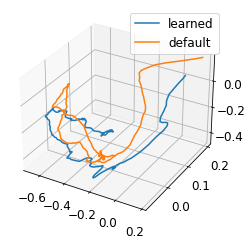

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos)),label='learned')
ax.plot(*list(zip(*dpos)),label='default')
ax.legend()

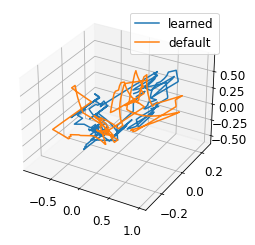

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos1)),label='learned')
ax.plot(*list(zip(*dpos1)),label='default')
ax.legend()

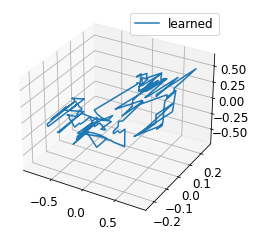

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos2)),label='learned')
# ax.plot(*list(zip(*dpos2)),label='default')
ax.legend()